In [148]:
import pandas as pd
from utils import *

df = pd.read_parquet("../data/preprocessed/combined.parquet")
# df["df_no_of_weekdays"] = df.groupby('dt_iso_year_week')['dt_iso_year_week'].transform('count')
# df["dt_iso_year_week"] = df["dt_iso_year_week"].str.re|place("-","", regex=False).astype("int")

# display(df[(df["df_no_of_weekdays"] == 7)])
display(df)

dt_iso_year_week  dt_year  dt_month  dt_day  \
date       ticker                                                
2020-01-01 NaN              2020-01     2020         1       1   
2020-01-02 MT.AS            2020-01     2020         1       2   
           IMCD.AS          2020-01     2020         1       2   
           RAND.AS          2020-01     2020         1       2   
           DSM.AS           2020-01     2020         1       2   
...                             ...      ...       ...     ...   
2021-08-05 WKL.AS           2021-31     2021         8       5   
           PHIA.AS          2021-31     2021         8       5   
           HEIA.AS          2021-31     2021         8       5   
           TKWY.AS          2021-31     2021         8       5   
           ASM.AS           2021-31     2021         8       5   

                    dt_day_of_week  dt_iso_week  dt_is_weekend  dt_is_week  \
date       ticker                                                            
2020-01-01 NaN                   2            0           True       False   
2020-01-02 MT.AS                 3            0           True       False   
           IMCD.AS               3            0           True       False   
           RAND.AS               3            0           True       False   
           DSM.AS                3            0           True       False   
...                            ...          ...            ...         ...   
2021-08-05 WKL.AS                3           31           True       False   
           PHIA.AS               3           31           True       False   
           HEIA.AS               3           31           True       False   
           TKWY.AS               3           31           True       False   
           ASM.AS                3           31           True       False   

                    dt_is_monday  dt_is_tuesday  dt_is_wednesday  \
date       ticker                                                  
2020-01-01 NaN                 0              0                1   
2020-01-02 MT.AS               0              0                0   
           IMCD.AS             0              0                0   
           RAND.AS             0              0                0   
           DSM.AS              0              0                0   
...                          ...            ...              ...   
2021-08-05 WKL.AS              0              0                0   
           PHIA.AS             0              0                0   
           HEIA.AS             0              0                0   
           TKWY.AS             0              0                0   
           ASM.AS              0              0                0   

                    dt_is_thursday  dt_is_friday  dt_is_saturday  \
date       ticker                                                  
2020-01-01 NaN                   0             0               0   
2020-01-02 MT.AS                 1             0               0   
           IMCD.AS               1             0               0   
           RAND.AS               1             0               0   
           DSM.AS                1             0               0   
...                            ...           ...             ...   
2021-08-05 WKL.AS                1             0               0   
           PHIA.AS               1             0               0   
           HEIA.AS               1             0               0   
           TKWY.AS               1             0               0   
           ASM.AS                1             0               0   

                    dt_is_sunday  infected  deceased        open        high  \
date       ticker                                                              
2020-01-01 NaN                 0         0         0    0.000000    0.000000   
2020-01-02 MT.AS               0         0         0   15.489909   15.795591   
           IMCD.AS             0         0         0   

# Feature selection and sampling

To sample our data correctly, we need to consider a few caveats:

- Stock exchange data is only available for weekdays. With preprocessing we forward fill the weekend days, but this means these days are static compared to all other data, as weather, COVID-19 and other data continues to develop. This leaves us with a few choices:
  - Ignore weekends and filter these days out. If our datapoints for each day are independent this should not affect model performance. On the other hand, if they are dependent, autoregressive models should perform worse than standard linear models.
  - Aggregate to week level data, but filter out incomplete weeks to ensure data consistency. This averages out are data, losing resolution, but increases reliability.
- Calendar data can be tricky with week, month and year transitions and it's effect on the data, but ideally the response variable fluctuates similarly with the input variable.
- For sampling, we need to align training and testing. A good rule of thumb is to 10 input datapoints to 1 reponse datapoint. For example, this means we sample 10 weeks of training data for 1 week of predictions. The testing data should be the week after the training data for the best effect, especially for autoregressive models.
- In this sampling we can try and distinguish between data sampled over two years compared to sampled within a single year.
- For reliability of the testing results, we can iterate over multiple training and testing samples and average out the testing score.

In [149]:
from numpy.random import RandomState

random_state = RandomState(0)

# Sample single stock
def sample_single_stock(df, retries=3):
    try:
        if retries <0:
            raise "Broken!"
        sample_stock = df.sample(random_state=random_state).index.get_level_values("ticker").to_list()[0]
        idx = pd.IndexSlice
        df = df.loc[idx[:, [sample_stock]], :]
    except:
        df = sample_single_stock(df, retries=retries-1)
    return df

df = sample_single_stock(df).reset_index(level=[0,1]).set_index("date")
# idx = pd.IndexSlice
# df = df.loc[idx[:, ["RDSA.AS"]], :].reset_index(level=[0,1]).set_index("date")
display(df)

,ticker,dt_iso_year_week,dt_year,dt_month,dt_day,dt_day_of_week,dt_iso_week,dt_is_weekend,dt_is_week,dt_is_monday,dt_is_tuesday,dt_is_wednesday,dt_is_thursday,dt_is_friday,dt_is_saturday,dt_is_sunday,infected,deceased,open,high,low,close,volume,is_original_stockdata,open_is_increase,open_is_decrease,open_is_equal,close_is_increase,close_is_decrease,close_is_equal,low_is_increase,low_is_decrease,low_is_equal,high_is_increase,high_is_decrease,high_is_equal,volume_is_increase,volume_is_decrease,volume_is_equal,total_doses,partial_vaccinations,full_vaccinations,daily_doses,24h_average_wind_speed,24h_average_temperature,24h_sum_of_precipitation,24h_average_air_pressure_converted_to_sea_level,24h_average_cloud_cover,24h_average_relative_humidity,c1_policyvalue_actual,c2_policyvalue_actual,c3_policyvalue_actual,c4_policyvalue_actual,c5_policyvalue_actual,c6_policyvalue_actual,c7_policyvalue_actual,c8_policyvalue_actual,e1_policyvalue_actual,e2_policyvalue_actual,e3_policyvalue_actual,e4_policyvalue_actual,h1_policyvalue_actual,h2_policyvalue_actual,h3_policyvalue_actual,h4_policyvalue_actual,h5_policyvalue_actual,h6_policyvalue_actual,h7_policyvalue_actual,h8_policyvalue_actual,v1_policyvalue_actual,v2_policyvalue_actual,v3_policyvalue_actual,stringency_actual
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,PHIA.AS,2020-01,2020,1,2,3,0,True,False,0,0,0,1,0,0,0,0,0,40.166925,40.729217,40.166925,40.535641,1529102.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0.0,41.0,39,0.0,10238.0,8.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,PHIA.AS,2020-01,2020,1,3,4,0,True,False,0,0,0,0,1,0,0,0,0,40.305199,40.434251,40.033271,40.346680,1468871.0,True,True,False,False,False,True,False,False,True,False,False,True,False,False,True,False,0,0,0,0.0,46.0,76,45.0,10188.0,7.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,PHIA.AS,2020-01,2020,1,4,5,0,False,True,0,0,0,0,0,1,0,0,0,40.305199,40.434251,40.033271,40.346680,1468871.0,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,0,0,0,0.0,35.0,67,11.0,10297.0,8.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,PHIA.AS,2020-01,2020,1,5,6,0,False,True,0,0,0,0,0,0,1,0,0,40.305199,40.434251,40.033271,40.346680,1468871.0,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,0,0,0,0.0,31.0,69,1.0,10330.0,8.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06,PHIA.AS,2020-02,2020,1,6,0,1,True,False,1,0,0,0,0,0,0,0,0,39.927261,40.231453,39.646117,40.130054,1644637.0,True,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,0,0,0,0.0,41.0,60,3.0,10240.0,7.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,PHIA.AS,2021-30,2021,8,1,6,30,False,True,0,0,0,0,0,0,1,2319,2,38.325001,39.009998,38.240002,38.889999,3773691.0,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,20254917,11855109,8657328,0.0,28.0,160,23.0,10099.0,6.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-02,PHIA.AS,2021-31,2021,8,2,0,31,True,False,1,0,0,0,0,0,0,2106,0,39.165001,39.415001,38.689999,38.959999,2850165.0,True,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,0,0,0,0.0,18.0,153,-1.0,10142.0,6.0,75.

In [150]:
from datetime import timedelta

total_pred_points = 2
train_test_ratio = 15 / 1
daily_weekly = 7 # set to 1 for daily

def sample_time_series(df, retries=10):
    try:
        if retries < 0:
            raise "Broken!"
        train_delta = int(total_pred_points * train_test_ratio * daily_weekly)
        train_week_start = str(df[(df.index + timedelta(int(train_delta * 1.1))) < max(df.index)].sample(random_state=random_state)["dt_iso_year_week"].to_list()[0])
        train_day_start = df[(df["dt_iso_year_week"] == train_week_start) & (df["dt_day_of_week"] == 0)].index[0]
        if (max(df.index) - train_day_start).days < int(train_delta * 1.1):
            train_week_start, train_start, train_end, test_start, test_end = sample_time_series(df, retries=retries-1)
        else:
            train_start, train_end, test_start, test_end = [train_day_start + timedelta(t) for t in [0, train_delta - 1, train_delta, int(train_delta * (1 + 1/train_test_ratio))]]
    except:
        train_week_start, train_start, train_end, test_start, test_end = sample_time_series(df, retries=retries-1)
    return train_week_start, train_start, train_end, test_start, test_end

train_week_start, train_start, train_end, test_start, test_end = sample_time_series(df, retries=10)

print("\n-  train week start:", train_week_start, "\n-  train start:", train_start, "\n-  train end:", train_end, "\n-  test start:", test_start, "\n-  test end:", test_end)


-  train week start: 2020-21 
-  train start: 2020-05-18 00:00:00 
-  train end: 2020-12-13 00:00:00 
-  test start: 2020-12-14 00:00:00 
-  test end: 2020-12-28 00:00:00


In [151]:
# Filtering or aggregating data for accuracy

df = df[df["is_original_stockdata"] == True]


df = df.drop([col for col in df.columns if "dt_" in col], axis=1)
df['date'] = pd.to_datetime(df.index) - pd.to_timedelta(daily_weekly, unit='d')
agg_cols = [col for col in df.columns if col != "date"]
df = df.groupby(["ticker", pd.Grouper(key='date', freq='W-MON')])[agg_cols].mean().reset_index().sort_values('date').set_index("date")

In [152]:
import datetime as dt
X_blacklist = ["ticker", "day_of_week", "dt_iso_year_week", 
               "dt_day_of_week", "dt_is_week", "dt_is_weekend", "volume"]
y_cols = ["open", "high", "low", "close"]
X_blacklist += [f"{y_col}_{incdec}" for y_col in y_cols + ["volume"] for incdec in ["is_equal", "is_increase", "is_decrease"]]
X_blacklist += [col for col in df.columns if "dt_" in col and col not in ['dt_is_monday', 'dt_is_tuesday', 'dt_is_wednesday', 'dt_is_thursday', 'dt_is_friday', 'dt_is_saturday', 'dt_is_sunday']]
X_blacklist += [col for col in df.columns if "policyvalue_actual" in col]
X_blacklist = list(set(X_blacklist))
y = df[y_cols]
X_cols = [col for col in df.columns if col not in y_cols and col not in X_blacklist]
X = df[X_cols]
X['date'] = X.index.map(dt.datetime.toordinal)

<ipython-input-152-f40dc8edeed2>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [153]:
X_train = X.loc[train_start:train_end].reset_index(drop=True)
y_train = y.loc[train_start:train_end].reset_index(drop=True)
X_test = X.loc[test_start:test_end].reset_index(drop=True)
y_test = y.loc[test_start:test_end].reset_index(drop=True)

In [154]:
display(X_train)

,infected,deceased,is_original_stockdata,total_doses,partial_vaccinations,full_vaccinations,daily_doses,24h_average_wind_speed,24h_average_temperature,24h_sum_of_precipitation,24h_average_air_pressure_converted_to_sea_level,24h_average_cloud_cover,24h_average_relative_humidity,stringency_actual,date
0,189.8,20.4,1.0,0.0,0.0,0.0,0.0,28.0,173.0,0.4,10233.2,5.0,65.6,28.520,737563
1,156.6,20.0,1.0,0.0,0.0,0.0,0.0,30.8,160.6,0.0,10306.6,3.8,60.0,26.852,737570
2,151.8,9.4,1.0,0.0,0.0,0.0,0.0,33.2,149.8,39.8,10053.8,7.2,71.8,12.592,737577
3,174.6,9.2,1.0,0.0,0.0,0.0,0.0,26.0,163.0,19.8,10141.2,6.8,73.4,11.852,737584
4,109.4,3.2,1.0,0.0,0.0,0.0,0.0,22.8,179.0,35.2,10157.4,5.6,77.6,23.704,737591
5,85.8,3.2,1.0,0.0,0.0,0.0,0.0,36.4,214.4,6.6,10172.8,3.2,58.8,0.000,737598
6,62.2,2.8,1.0,0.0,0.0,0.0,0.0,44.4,167.2,48.2,10113.0,6.8,75.4,7.962,737605
7,57.6,2.0,1.0,0.0,0.0,0.0,0.0,25.6,155.4,29.6,10165.2,6.8,82.0,15.924,737612
8,123.6,3.2,1.0,0.0,0.0,0.0,0.0,19.4,164.6,13.8,10178.0,6.2,78.4,7.962,737619
9,173.4,1.0,1.0,0.0,0.0,0.0,0.0,26.4,168.6,1.0,10172.8,5.8,70.6,0.000,737626


In [155]:
display(y_train)

,open,high,low,close
0,38.150636,38.832199,37.912135,38.635178
1,38.646490,39.152714,37.948901,38.367455
2,38.748303,39.261126,38.303353,38.983032
3,38.319378,38.995287,37.694375,38.201542
4,39.041479,39.787145,38.835029,39.359164
5,39.344080,39.798457,38.904788,39.307315
6,41.675799,41.995054,41.187588,41.811359
7,41.616863,42.115879,41.217058,41.614897
8,42.704286,43.490139,42.265190,43.124718
9,44.220984,44.534345,43.797606,44.263224


In [156]:
display(X_test)

,infected,deceased,is_original_stockdata,total_doses,partial_vaccinations,full_vaccinations,daily_doses,24h_average_wind_speed,24h_average_temperature,24h_sum_of_precipitation,24h_average_air_pressure_converted_to_sea_level,24h_average_cloud_cover,24h_average_relative_humidity,stringency_actual,date
0,10737.40,72.00,1.0,0.0,0.0,0.0,0.0,40.60,81.20,52.20,10139.20,7.60,91.20,30.000,737773
1,9776.75,84.50,1.0,0.0,0.0,0.0,0.0,33.75,76.25,77.25,10021.25,7.75,90.75,19.675,737780
2,8316.00,115.75,1.0,0.0,0.0,0.0,0.0,30.50,32.00,22.75,10020.75,7.50,91.00,19.675,737787


In [157]:
display(y_test)

,open,high,low,close
0,43.098195,43.585425,42.535326,43.062830
1,43.138470,43.584197,43.023048,43.358264
2,43.819953,44.221476,43.474915,43.835917


In [158]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('feature_selection', RFECV(LinearRegression())),
    ('lr', LinearRegression())
])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)
# Pipeline(steps=[
#     ('scaler', StandardScaler()), 
#     ('lr', LinearRegression())
# ])
# pipe.score(X_test, y_test)
y_pred = pipe.predict(X_test)

scores_regr = metrics.mean_squared_error(y_test, y_pred)
print(scores_regr)

1.4888597783232944


In [159]:

X_train_df = X_train.set_index(df.loc[train_start:train_end].index)
y_train_df = y_train.set_index(df.loc[train_start:train_end].index)
y_pred_df = pd.DataFrame(y_pred, columns=y_cols, index=df.loc[test_start:test_end].index)
y_test_df = y_test.set_index(df.loc[test_start:test_end].index)

# for _ in [X_train_df, y_train_df, y_pred_df, y_test_df]:
#     _ = _[(_["dt_is_saturday"] == False) & (_["dt_is_sunday"] == False)]

In [160]:
display(X_train_df)

,infected,deceased,is_original_stockdata,total_doses,partial_vaccinations,full_vaccinations,daily_doses,24h_average_wind_speed,24h_average_temperature,24h_sum_of_precipitation,24h_average_air_pressure_converted_to_sea_level,24h_average_cloud_cover,24h_average_relative_humidity,stringency_actual,date
date,,,,,,,,,,,,,,,
2020-05-18,189.8,20.4,1.0,0.0,0.0,0.0,0.0,28.0,173.0,0.4,10233.2,5.0,65.6,28.520,737563
2020-05-25,156.6,20.0,1.0,0.0,0.0,0.0,0.0,30.8,160.6,0.0,10306.6,3.8,60.0,26.852,737570
2020-06-01,151.8,9.4,1.0,0.0,0.0,0.0,0.0,33.2,149.8,39.8,10053.8,7.2,71.8,12.592,737577
2020-06-08,174.6,9.2,1.0,0.0,0.0,0.0,0.0,26.0,163.0,19.8,10141.2,6.8,73.4,11.852,737584
2020-06-15,109.4,3.2,1.0,0.0,0.0,0.0,0.0,22.8,179.0,35.2,10157.4,5.6,77.6,23.704,737591
2020-06-22,85.8,3.2,1.0,0.0,0.0,0.0,0.0,36.4,214.4,6.6,10172.8,3.2,58.8,0.000,737598
2020-06-29,62.2,2.8,1.0,0.0,0.0,0.0,0.0,44.4,167.2,48.2,10113.0,6.8,75.4,7.962,737605
2020-07-06,57.6,2.0,1.0,0.0,0.0,0.0,0.0,25.6,155.4,29.6,10165.2,6.8,82.0,15.924,737612
2020-07-13,123.6,3.2,1.0,0.0,0.0,0.0,0.0,19.4,164.6,13.8,10178.0,6.2,78.4,7.962,737619


In [161]:
display(y_train_df)

,open,high,low,close
date,,,,
2020-05-18,38.150636,38.832199,37.912135,38.635178
2020-05-25,38.646490,39.152714,37.948901,38.367455
2020-06-01,38.748303,39.261126,38.303353,38.983032
2020-06-08,38.319378,38.995287,37.694375,38.201542
2020-06-15,39.041479,39.787145,38.835029,39.359164
2020-06-22,39.344080,39.798457,38.904788,39.307315
2020-06-29,41.675799,41.995054,41.187588,41.811359
2020-07-06,41.616863,42.115879,41.217058,41.614897
2020-07-13,42.704286,43.490139,42.265190,43.124718


In [162]:
pd.set_option('display.max_columns', None)
display(X_test)

,infected,deceased,is_original_stockdata,total_doses,partial_vaccinations,full_vaccinations,daily_doses,24h_average_wind_speed,24h_average_temperature,24h_sum_of_precipitation,24h_average_air_pressure_converted_to_sea_level,24h_average_cloud_cover,24h_average_relative_humidity,stringency_actual,date
0,10737.40,72.00,1.0,0.0,0.0,0.0,0.0,40.60,81.20,52.20,10139.20,7.60,91.20,30.000,737773
1,9776.75,84.50,1.0,0.0,0.0,0.0,0.0,33.75,76.25,77.25,10021.25,7.75,90.75,19.675,737780
2,8316.00,115.75,1.0,0.0,0.0,0.0,0.0,30.50,32.00,22.75,10020.75,7.50,91.00,19.675,737787


In [163]:
display(y_test_df)

,open,high,low,close
date,,,,
2020-12-14,43.098195,43.585425,42.535326,43.062830
2020-12-21,43.138470,43.584197,43.023048,43.358264
2020-12-28,43.819953,44.221476,43.474915,43.835917


In [164]:
display(y_pred_df)

,open,high,low,close
date,,,,
2020-12-14,42.148050,42.567543,41.738883,42.091317
2020-12-21,42.221304,42.636680,41.814663,42.160398
2020-12-28,42.294558,42.705818,41.890443,42.229478


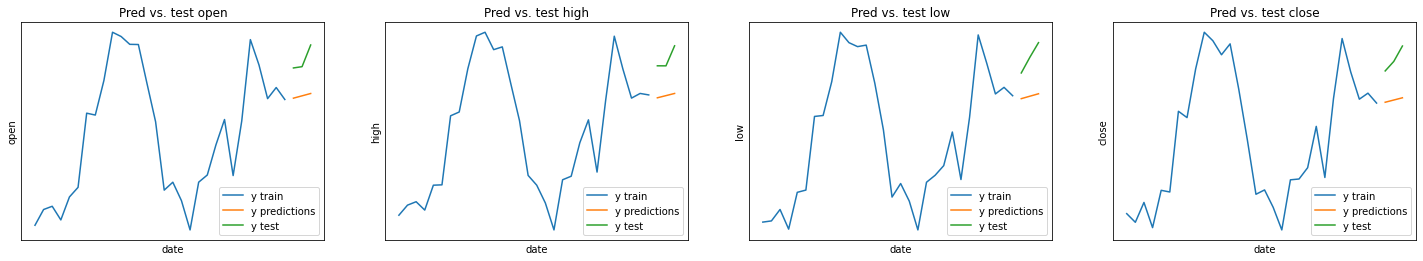

In [165]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 4))
for i, col in enumerate(y_cols):
    ax = plt.subplot(1, len(y_cols), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    plt.plot(y_train_df.index, y_train_df[col], label="y train")
    plt.plot(y_pred_df.index, y_pred_df[col], label="y predictions")
    plt.plot(y_test_df.index, y_test_df[col], label="y test")
    
    plt.xlabel("date")
    plt.ylabel(col)
    plt.legend(loc="best")
    plt.title(f"Pred vs. test {col}")
plt.show()

In [166]:
# X_train_df = X_train.set_index(pd.date_range(start=train_start, end=train_end, freq="D"))
# y_train_df = y_train.set_index(pd.date_range(start=train_start, end=train_end, freq="D"))
# # y_pred_df = pd.DataFrame(y_pred, columns=y_cols, index=pd.date_range(start=test_start, end=test_end, freq="D"))
# y_test_df = y_test.set_index(pd.date_range(start=test_start, end=test_end, freq="D"))

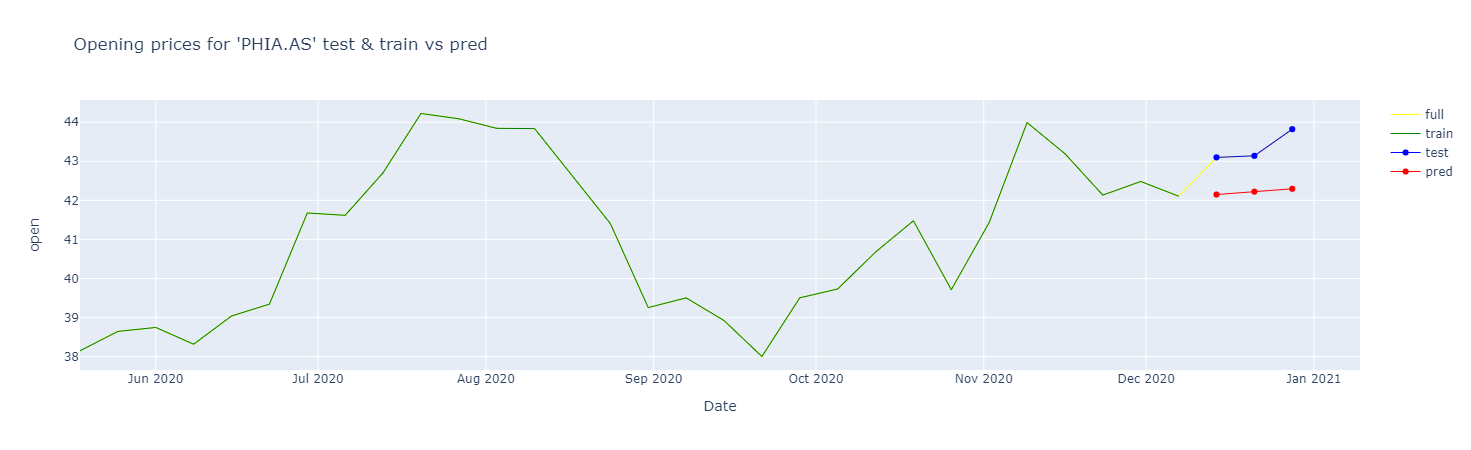

In [167]:
import plotly.graph_objects as go
fig = go.Figure()


fig.add_trace(go.Scatter(x=df.loc[train_start:test_end].index, y=df.loc[train_start:test_end]["open"], name="full", line=dict(color="yellow", width=1)))
fig.add_trace(go.Scatter(x=y_train_df.index, y=y_train_df["open"], name="train", line=dict(color="green", width=1)))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df["open"], name="test", line=dict(color="blue", width=1)))
fig.add_trace(go.Scatter(x=y_pred_df.index, y=y_pred_df["open"], name="pred", line=dict(color="red", width=1)))

# Edit the layout
fig.update_layout(title=f"Opening prices for '{df.ticker.to_list()[0]}' test & train vs pred ", xaxis_title='Date', yaxis_title='open')

fig.show()


In [168]:
from IPython.display import display, Markdown, Latex
header = """## Government measures

Current government measures in training and testing data listed

"""
government_measures = list_government_measures(df[(df.stringency_actual > 0) & (df.index >= train_start) & (df.index <= test_end)].index.astype("str").to_list())
display(Markdown(header + government_measures))

## Government measures

Current government measures in training and testing data listed

- '2020-05-25':
  - H8:
    - notes: 'Care homes One care home in each GGD region is currently admitting a
        limited number of visitors under strict conditions. From 25 May the policy
        will be extended to more care homes. The government expects to be able to
        adapt the visiting policy for all care homes from 15 June. "From May 25, nursing
        home organizations can again allow limited visits. Minister De Jonge wrote
        this in his letter to the Lower House on Tuesday 19 May. De Jonge announced
        that between May 25 and June 15, all nursing homes that meet the preconditions
        can allow visits again under certain conditions. The conditions for visits
        apply until July 15th. Only after that date is a further relaxation of the
        visiting schedule possible." Sources: https://web.archive.org/web/20210322215259/https://www.government.nl/ministries/ministry-of-health-welfare-and-sport/news/2020/05/19/tackling-coronavirus-the-next-step
        https://archive.vn/ytTYQ'
    - policy_type_display: Protection of elderly people
    - policyvalue_actual: '2'
    - confirmed: 45445
    - country_code: NLD
    - date_value: '2020-05-25'
    - deaths: 5830
    - stringency: 71.3
    - stringency_actual: 71.3
- '2020-06-01':
  - C2:
    - notes: On June 1 2020, several measures were relaxed in the Netherlands. Buildings
        and other covered areas includes cafes, bars, restaurants, libraries, cinemas,
        theatres, concert halls, heritage sites, music schools, art centres and museums
        open to the public can now admit up to 30 people at a time inside, not counting
        staff. Outdoor seating areas in cafes, bars and restaurants have been reopened.
        Funerals, marriage ceremonies and religious or ideological gatherings may
        be held but must not exceed 30 people. Most people in contact-based roles
        are able to perform their jobs again. This includes driving instructors, health-related
        professionals (dieticians, masseurs, occupational therapists, prosthodontists,
        etc.), hair and beauty professionals (beauticians, hairdressers, pedicurists,
        etc.) and alternative medicine practitioners (acupuncturists and homeopaths,
        etc.). http://web.archive.org/web/20200610123042/https://www.government.nl/topics/coronavirus-covid-19/news/2020/05/28/press-conference-of-27-may-current-roadmap-of-measures-against-coronavirus
        http://web.archive.org/web/20200610124407/https://www.government.nl/topics/coronavirus-covid-19/tackling-new-coronavirus-in-the-netherlands/public-life
    - policy_type_display: Workplace closing
    - policyvalue_actual: '2.0'
    - confirmed: 46545
    - country_code: NLD
    - date_value: '2020-06-01'
    - deaths: 5962
    - stringency: 62.96
    - stringency_actual: 62.96
  - C4:
    - notes: "On June 1 2020, several measures were relaxed in the Netherlands. Buildings\
        \ and other covered areas includes cafes, bars, restaurants, libraries, cinemas,\
        \ theatres, concert halls, heritage sites, music schools, art centres and\
        \ museums open to the public can now admit up to 30 people at a time inside,\
        \ not counting staff. Outdoor seating areas in cafes, bars and restaurants\
        \ have been reopened. There is no maximum number of people for outdoor seating\
        \ areas, but all guests must sit at tables and people who do not live together\
        \ must stay 1.5 metres apart. Funerals, marriage ceremonies and religious\
        \ or ideological gatherings may be held but must not exceed 30 people. People\
        \ must always stay 1.5 metres apart. Other indoor gatherings with more than\
        \ 30 people are permitted in these 2 cases only: gatherings required by law,\
        \ such as parliamentary and municipal council meetings and some shareholders\u2019\
        \ meetings, can be held online. Physical gatherings are permitted but must\
        \ not exceed 100 people. Participants must stay at least 1.5 metres away from\
        \ one another; gatherings necessary to ensure the continued daily operation\
        \ of institutions, businesses and other organisations are permitted but must\
        \ not exceed 100 people. Participants must stay at least 1.5 metres away from\
        \ one another. From 1 June young people aged 13 to 18 are also allowed to\
        \ take part in organised sports activities outdoors under the supervision\
        \ of sports clubs or professionals, without keeping a distance of 1.5 metres.\
        \ This is already the case for children aged 12 and under. Competitions and\
        \ matches remain prohibited. There is no maximum number of people for gatherings\
        \ in homes. http://web.archive.org/web/20200610124407/https://www.government.nl/topics/coronavirus-covid-19/tackling-new-coronavirus-in-the-netherlands/public-life\
        \ http://web.archive.org/web/20200610123042/https://www.government.nl/topics/coronavirus-covid-19/news/2020/05/28/press-conference-of-27-may-current-roadmap-of-measures-against-coronavirus"
    - policy_type_display: Restrictions on gatherings
    - policyvalue_actual: '3.0'
    - confirmed: 46545
    - country_code: NLD
    - date_value: '2020-06-01'
    - deaths: 5962
    - stringency: 62.96
    - stringency_actual: 62.96
  - C5:
    - notes: On June 1 2020, several measures were relaxed in the Netherlands. From
        1 June, public transport in the Netherlands is running again (more or less)
        according to the 'normal' timetable. However, public transport is still recommended
        only for essential travel and as of June 1, all passengers aged 13 and over
        will be required to wear a non-medical face mask on buses, metros, trams,
        ferries, water-buses and trains. http://web.archive.org/web/20200610125934/https://9292.nl/en/news/news-items/public-transportation-and-the-corona-virus
        http://web.archive.org/web/20200610124407/https://www.government.nl/topics/coronavirus-covid-19/tackling-new-coronavirus-in-the-netherlands/public-life
        http://web.archive.org/web/20200610130126/https://www.vcktravel.nl/en/news-en/train-traffic-back-to-normal-schedule/
    - policy_type_display: Close public transport
    - policyvalue_actual: '0.0'
    - confirmed: 46545
    - country_code: NLD
    - date_value: '2020-06-01'
    - deaths: 5962
    - stringency: 62.96
    - stringency_actual: 62.96
  - H2:
    - notes: On June 1 2020, several measures were relaxed in the Netherlands. From
        1 June, anyone with mild symptoms that may point to coronavirus will be able
        to phone a national hotline and make an appointment to be tested by the municipal
        health service (GGD). Loss of smell or taste have been added to the list of
        symptoms that may point to a coronavirus infection. http://web.archive.org/web/20200610123042/https://www.government.nl/topics/coronavirus-covid-19/news/2020/05/28/press-conference-of-27-may-current-roadmap-of-measures-against-coronavirus
    - policy_type_display: Testing policy
    - policyvalue_actual: '2.0'
    - confirmed: 46545
    - country_code: NLD
    - date_value: '2020-06-01'
    - deaths: 5962
    - stringency: 62.96
    - stringency_actual: 62.96
  - H3:
    - notes: On June 1st capacity for contact tracing was expanded in line with the
        expanded testing capacity to cover everyone who has symptoms. Complete contact
        tracing will be done for everyone who has tested positive for Covid-19. file:///Users/ingridjohansen/Downloads/Testen_Bron-Contact_EN.pdf
        https://www.dutchnews.nl/news/2020/05/face-masks-testing-and-an-app-what-the-dutch-are-doing/
    - policy_type_display: Contact tracing
    - policyvalue_actual: '2.0'
    - confirmed: 46545
    - country_code: NLD
    - date_value: '2020-06-01'
    - deaths: 5962
    - stringency: 62.96
    - stringency_actual: 62.96
  - H6:
    - notes: From 1 June 2020 public transport is running more as normal and as of
        June 1 2020, all passengers aged 13 and over will be required to wear a non-medical
        face mask on buses, metros, trams, ferries, water-buses and trains. http://web.archive.org/web/20200610125934/https://9292.nl/en/news/news-items/public-transportation-and-the-corona-virus
        http://web.archive.org/web/20200610124407/https://www.government.nl/topics/coronavirus-covid-19/tackling-new-coronavirus-in-the-netherlands/public-life
        http://web.archive.org/web/20200610130126/https://www.vcktravel.nl/en/news-en/train-traffic-back-to-normal-schedule/
    - policy_type_display: Facial Coverings
    - policyvalue_actual: '2.0'
    - confirmed: 46545
    - country_code: NLD
    - date_value: '2020-06-01'
    - deaths: 5962
    - stringency: 62.96
    - stringency_actual: 62.96
  - M1:
    - notes: 'As of June 1st, it is compulsory to wear masks on all public transport
        (bus, train, metro, tram). No clear end date has been set for when this will
        no longer be applicable. http://web.archive.org/web/20200720094156/https://www.dutchnews.nl/news/2020/05/dutch-start-easing-coronavirus-restrictions-face-masks-a-must-on-public-transport/ '
    - policy_type_display: Wildcard
    - policyvalue_actual: None
    - confirmed: 46545
    - country_code: NLD
    - date_value: '2020-06-01'
    - deaths: 5962
    - stringency: 62.96
    - stringency_actual: 62.96
- '2020-06-08':
  - C1:
    - notes: From 8 June, primary schools opened for all pupils for the full school
        day. They had been open only for half of pupils at a time. Out-of-school care
        (BSO) reopened fully on 8 June and children are able to attend on their regular
        days again. From 8 June emergency childcare is only available for the children
        of healthcare professionals working evening, night or weekend shifts (until
        1 July). Secondary schools, including special secondary schools, are open.
        Schools for secondary vocational education (MBO) will be able to open for
        tests and practical training from 15 June. Similarly, institutions for higher
        professional education (HBO) and universities will be allowed to reopen for
        exams, practical training and to provide support to vulnerable students as
        of 15 June. http://web.archive.org/web/20200610132121/https://www.government.nl/topics/coronavirus-covid-19/tackling-new-coronavirus-in-the-netherlands/public-life
    - policy_type_display: School closing
    - policyvalue_actual: '2'
    - confirmed: 47739
    - country_code: NLD
    - date_value: '2020-06-08'
    - deaths: 6016
    - stringency: 62.96
    - stringency_actual: 62.96
- '2020-06-15':
  - C1:
    - notes: As of 15 June 2020, all schools and universities in the Netherlands are
        open. This completes the gradual opening up of the school system. However
        colleges and universities are still recommended to teach as much as possible
        on-line. Only a limited amount of educational activities can take place in
        colleges and universities, such as exams. http://web.archive.org/web/20200618195856/https://www.rijksoverheid.nl/onderwerpen/coronavirus-covid-19/ouders-scholieren-en-studenten-kinderopvang-en-onderwijs/hogescholen-en-universiteiten-hoger-onderwijs
        ** Per coding guidelines, "If a narrowly defined list of university courses
        which rely on essential in-person teaching, for example medical programs,
        are permitted to operate as an exemption, but all other in-person university
        teaching is cancelled, we treat this as a closure of universities." - guidance
        notes that "The limited educational activities that may take place again at
        colleges and universities from 15 June are only for practical lessons, exams,
        exams and guidance of vulnerable students insofar as this is not possible
        online." - consider coding as 2 rather than 1
    - policy_type_display: School closing
    - policyvalue_actual: '1'
    - confirmed: 48948
    - country_code: NLD
    - date_value: '2020-06-15'
    - deaths: 6065
    - stringency: 59.26
    - stringency_actual: 59.26
  - C8:
    - notes: As of 15 June 2020, the Dutch can travel to 16 countries within the EU/Schengen
        for summer holidays. The countries include Belgium, Bulgaria, Germany, Estonia,
        France, Iceland, Italy, Croatia, Latvia, Liechtenstein, Lithuania, Luxembourg,
        Poland, Portugal, the Czech Republic and Switzerland. Existing travel restrictions
        into the Netherlands for non-EU citizens have been extended until July 1 2020
        http://web.archive.org/web/20200618194936/https://www.rijksoverheid.nl/actueel/nieuws/2020/06/15/nederlanders-kunnen-weer-op-vakantie-in-16-europese-landen
        http://web.archive.org/web/20200618193140/https://www.rijksoverheid.nl/actueel/nieuws/2020/06/15/nederland-verlengt-de-grenssluiting-voor-mensen-van-buiten-europa
    - policy_type_display: International travel controls
    - policyvalue_actual: '3'
    - confirmed: 48948
    - country_code: NLD
    - date_value: '2020-06-15'
    - deaths: 6065
    - stringency: 59.26
    - stringency_actual: 59.26
  - H8:
    - notes: '"At the end of May, the cabinet decided that a maximum of 1 regular
        visitor would have access to the nursing home until 15 July. (...) On 3 June,
        the cabinet amended its decision and stated that nursing homes could allow
        more visits from 15 June where it is safe and responsible." Source: https://archive.vn/Yyrgb#selection-955.0-967.106'
    - policy_type_display: Protection of elderly people
    - policyvalue_actual: '1'
    - confirmed: 48948
    - country_code: NLD
    - date_value: '2020-06-15'
    - deaths: 6065
    - stringency: 59.26
    - stringency_actual: 59.26
- '2020-08-03':
  - C1:
    - notes: 'Same rules apply. Schools are open and as of 1 July, pupils no longer
        need to stay 1.5 metres from each other. This applies to all secondary school
        pupils, regardless of their age. In the new school year, secondary schools
        will be able to provide the regular number of teaching hours to all pupils.
        For secondary schools, universities and HBO: Lectures and classes continue
        to be staggered over the week and day, to spread the number of students travelling
        to and from their institution by public transport. Teaching is organised so
        that students do not or hardly have to commute by public transport during
        peak hours. '
    - policy_type_display: School closing
    - policyvalue_actual: '1'
    - confirmed: 55470
    - country_code: NLD
    - date_value: '2020-08-03'
    - deaths: 6149
    - stringency: 39.81
    - stringency_actual: 39.81
  - C2:
    - notes: 'Rules remain unchanged: All sectors of society are open with the exception
        of discos and nightclubs that remain closed until September 1. Also, Singing
        along at concerts or church services, for example, is not allowed. https://www.government.nl/topics/coronavirus-covid-19/tackling-new-coronavirus-in-the-netherlands/public-life
        ** Confirmed details are correct, and updated with archived link - https://web.archive.org/web/20200803094755/https://www.government.nl/topics/coronavirus-covid-19/tackling-new-coronavirus-in-the-netherlands/public-life'
    - policy_type_display: Workplace closing
    - policyvalue_actual: '2'
    - confirmed: 55470
    - country_code: NLD
    - date_value: '2020-08-03'
    - deaths: 6149
    - stringency: 39.81
    - stringency_actual: 39.81
  - C3:
    - notes: 'Same rules apply. The ban on events that require a permit was lifted
        from 1 July. It is up to local authorities to decide whether event organisers
        can ensure attendees can stay 1.5 metres apart and if other specific conditions
        apply. Public events are permitted subject to being able to maintain social
        distancing. At outdoor locations where there is a continuous flow of people,
        such as shopping streets, zoos or fairs, no maximum number of people applies.
        At outdoor locations where there is not a continuous flow of people, no maximum
        number of people applies provided that they have made reservations, undergone
        a pre-entry health check and have their own seat. Spectators were permitted
        at matches and competitions as of 1 July. https://www.government.nl/topics/coronavirus-covid-19/tackling-new-coronavirus-in-the-netherlands/public-life '
    - policy_type_display: Cancel public events
    - policyvalue_actual: '0'
    - confirmed: 55470
    - country_code: NLD
    - date_value: '2020-08-03'
    - deaths: 6149
    - stringency: 39.81
    - stringency_actual: 39.81
  - C4:
    - notes: 'Rules remain unchanged: For public gatherings where there is no reservation
        / no pre-entry health check / no fixed seat- gatherings outside there is a
        maximum of 250 people and for gatherings inside there is a maximum of 100
        people. Social distancing applies. https://www.government.nl/topics/coronavirus-covid-19/tackling-new-coronavirus-in-the-netherlands/public-life
        https://www.containmentnu.nl/en/articles/timeline'
    - policy_type_display: Restrictions on gatherings
    - policyvalue_actual: '2'
    - confirmed: 55470
    - country_code: NLD
    - date_value: '2020-08-03'
    - deaths: 6149
    - stringency: 39.81
    - stringency_actual: 39.81
  - C5:
    - notes: 'No policy change. Public transport time table back to usual amount since
        June 1st combined with mandatory wearing of face masks. '
    - policy_type_display: Close public transport
    - policyvalue_actual: '0'
    - confirmed: 55470
    - country_code: NLD
    - date_value: '2020-08-03'
    - deaths: 6149
    - stringency: 39.81
    - stringency_actual: 39.81
  - C6:
    - notes: 'No change in rules. People should stay home if they show any symptoms
        of Covid 19 and are still encouraged to work from home if possible, avoid
        peak hours on public transport and avoid busy areas if possible. https://www.government.nl/topics/coronavirus-covid-19/tackling-new-coronavirus-in-the-netherlands/public-life '
    - policy_type_display: Stay at home requirements
    - policyvalue_actual: '1'
    - confirmed: 55470
    - country_code: NLD
    - date_value: '2020-08-03'
    - deaths: 6149
    - stringency: 39.81
    - stringency_actual: 39.81
  - C7:
    - notes: No change. People are around to move around the Netherlands freely however
        it is recommended to avoid public transport at peak hours. https://www.government.nl/topics/coronavirus-covid-19/tackling-new-coronavirus-in-the-netherlands/public-life
    - policy_type_display: Restrictions on internal movement
    - policyvalue_actual: '0'
    - confirmed: 55470
    - country_code: NLD
    - date_value: '2020-08-03'
    - deaths: 6149
    - stringency: 39.81
    - stringency_actual: 39.81
  - C8:
    - notes: "External borders remain closed (with some specific exceptions to the\
        \ Netherlands and the other Schengen countries as well as the United Kingdom\
        \ to people from outside the EU whose journey is not essential. Entry from\
        \ several countries within the EU (for example Sweden) now require a 2 week\
        \ house quarantine if entering the Netherlands. Latest update: Travellers\
        \ from Sweden, Romania, Bulgaria, 2 areas in Spain (Segri\xE0 and La Mari\xF1\
        a-Lugo) and 1 area in Portugal (Vale do Tejo, this includes Lisbon) and 1\
        \ area in the United Kingdom (Leicester), are strongly advised to self-quarantine\
        \ for 14 days on arrival in the Netherlands. https://www.government.nl/topics/coronavirus-covid-19/tackling-new-coronavirus-in-the-netherlands/travel-and-holidays/visiting-the-netherlands"
    - policy_type_display: International travel controls
    - policyvalue_actual: '3'
    - confirmed: 55470
    - country_code: NLD
    - date_value: '2020-08-03'
    - deaths: 6149
    - stringency: 39.81
    - stringency_actual: 39.81
  - E1:
    - notes: Rules remain in place. For employers support remains in place to ensure
        that they can continue to pay their employees (the scheme is called 'NOW').
        The aim of the second NOW application period is to preserve as many jobs as
        possible. The second NOW application period started on Monday 6 July. Until
        31 August 2020, employers can again apply for a NOW allowance. This allows
        them to continue paying their employees. The second NOW compensation is for
        a period of 4 months covering June-September 2020. However applications for
        support for temporary workers (students with a side job, temporary workers
        or people with zero hour contracts) ended on July 27th. Due to the corona
        crisis, the Temporary Bridging Scheme for Flexible Workers (TOFA) was created.
        The TOFA was intended for flex workers who have lost at least half of their
        income and who cannot receive benefits. https://www.uwv.nl/werkgevers/overige-onderwerpen/now/tweede-aanvraagperiode-now/index.aspx
        https://www.uwv.nl/particulieren/overige-onderwerpen/tofa/index.aspx
    - policy_type_display: Income support
    - policyvalue_actual: '2'
    - confirmed: 55470
    - country_code: NLD
    - date_value: '2020-08-03'
    - deaths: 6149
    - stringency: 39.81
    - stringency_actual: 39.81
  - H2:
    - notes: Rules remain unchanged. Since 1 June, anyone with mild symptoms that
        may point to coronavirus will be able to phone a national hotline and make
        an appointment to be tested by the municipal health service (GGD) https://www.rivm.nl/en/novel-coronavirus-covid-19/testing-for-covid-19
    - policy_type_display: Testing policy
    - policyvalue_actual: '2'
    - confirmed: 55470
    - country_code: NLD
    - date_value: '2020-08-03'
    - deaths: 6149
    - stringency: 39.81
    - stringency_actual: 39.81
  - H3:
    - notes: Situation remains the same since June 1st when capacity for contact tracing
        was expanded in line with the expanded testing capacity to cover everyone
        who has symptoms. Complete contact tracing will be done for everyone who has
        tested positive for Covid-19. file:///Users/ingridjohansen/Downloads/Testen_Bron-Contact_EN.pdf
        https://www.dutchnews.nl/news/2020/05/face-masks-testing-and-an-app-what-the-dutch-are-doing/
    - policy_type_display: Contact tracing
    - policyvalue_actual: '2'
    - confirmed: 55470
    - country_code: NLD
    - date_value: '2020-08-03'
    - deaths: 6149
    - stringency: 39.81
    - stringency_actual: 39.81
- '2020-08-17':
  - C1:
    - notes: 'Schools have begun to reopen again. The following measures are being
        implemented: Since children play a minor role in the spread of the virus,
        the 1.5 metre measure is less strict for young children: * Children up to
        and including 12 years of age do not have to keep 1.5 metres apart from each
        other and from adults. * Young people aged 13 until 18 years old (i.e. 17
        years old and younger) do not have to stay 1.5 metres apart from each other.
        In secondary schools, this applies to all pupils, regardless of their age.
        * In secondary vocational education (MBO) and higher education, all students
        should stay 1.5 metres apart, regardless of their age; * Since adults play
        a greater role in the spread of the novel coronavirus, teachers need to stay
        1.5 metres apart from others whenever possible. Some schools are requiring
        older students to wear masks in corridors due to lack of space. Schools are
        also being urged to make sure that they have proper ventilation. Extra hygiene
        measures have also been put in place. In addition, children must stay at home
        in case someone in their household tests positive and until they are authorized
        to returned to school. Sources: https://web.archive.org/web/20200812124744/https://www.government.nl/latest/news/2020/08/06/regaining-control-over-coronavirus-with-local-measures
        https://www.dutchnews.nl/news/2020/08/coronavirus-in-the-netherlands-what-you-need-to-know-update-august-19/
        http://web.archive.org/web/20200822174017/https://www.bbc.com/news/explainers-53640249
        http://web.archive.org/web/20200819180114/https://www.rivm.nl/en/novel-coronavirus-covid-19/children-and-covid-19 '
    - policy_type_display: School closing
    - policyvalue_actual: '1'
    - confirmed: 63484
    - country_code: NLD
    - date_value: '2020-08-17'
    - deaths: 6172
    - stringency: 39.81
    - stringency_actual: 39.81
- '2020-08-31':
  - C1:
    - notes: Government confirms that as of Monday 31 August 2020 all schools (primary
        and secondary) are fully open in netherlands after the summer holidays. The
        rules include washing your hands regularly, staying at home with complaints
        and having them tested. A distance of a meter and a half between students
        is not necessary, in secondary schools, it is preferred between students and
        adults. Masks are not necessary. http://web.archive.org/web/20200902190559/https://www.rijksoverheid.nl/actueel/nieuws/2020/08/31/alle-scholen-weer-open
        ** 1G coding confirmed, in addition to the school measures noted above, University
        and College students are returning to in-person education with staggered schedules,
        some classes online, and 1.5 meter social distancing measure between students
        and staff in place - http://web.archive.org/web/20200831163634/https://www.rijksoverheid.nl/onderwerpen/coronavirus-covid-19/ouders-scholieren-en-studenten-kinderopvang-en-onderwijs/hogescholen-en-universiteiten-hoger-onderwijs
    - policy_type_display: School closing
    - policyvalue_actual: '1'
    - confirmed: 70667
    - country_code: NLD
    - date_value: '2020-08-31'
    - deaths: 6224
    - stringency: 50.93
    - stringency_actual: 50.93
  - H6:
    - notes: The cities of Amsterdam and Rotterdam have announced that they will no
        longer require face masks in certain parts of the city, a policy that had
        started on 5 August and was meant to go until the end of August as an 'experiment.'
        Both cities said they will wait until the results of the experiment whether
        to see if they reintroduce face masks. https://www.dutchnews.nl/news/2020/08/amsterdam-and-rotterdam-stop-requiring-face-masks-in-busy-places/
    - policy_type_display: Facial Coverings
    - policyvalue_actual: '2'
    - confirmed: 70667
    - country_code: NLD
    - date_value: '2020-08-31'
    - deaths: 6224
    - stringency: 50.93
    - stringency_actual: 50.93
- '2020-09-14':
  - C8:
    - notes: Government announced that there will be some easing of restrictions on
        the ban on entry as of September 14 2020 for top athletes - meaning that they
        can enter the Netherlands with authorisation even if they are coming from
        countries that are banned from entry to the Netherlands due to Covid-19. http://web.archive.org/web/20200914184837/https://www.rijksoverheid.nl/onderwerpen/coronavirus-covid-19/nieuws/2020/09/11/uitzonderingen-inreisverbod-nederland-onder-strikte-voorwaarden
    - policy_type_display: International travel controls
    - policyvalue_actual: '3'
    - confirmed: 83399
    - country_code: NLD
    - date_value: '2020-09-14'
    - deaths: 6256
    - stringency: 50.93
    - stringency_actual: 50.93
- '2020-09-21':
  - E3:
    - notes: "On 21 Sept 2020, the new government plans for 2021 were announced. They\
        \ included the following covid-19-related fiscal measures: - \u20AC500 million\
        \ to combat delays in education due to covid-19 - \u20AC482 million to support\
        \ artists and professionals in the creative sector during the covid-19-crisis\
        \ - \u20AC40 million to deal with backlog in criminal justice system due to\
        \ covid-19 - \u20AC1.4 billion to help people find another job and tackle\
        \ debt due to covid-19 - \u20AC2 billion extra investment in infrastructure\
        \ and housing construction due to covid-19 Total: \u20AC4.422 billion. To\
        \ USD: 4422*1.0803280554=4777.2106609788. http://web.archive.org/web/20201026185946/https://www.rijksoverheid.nl/regering/plannen-kabinet-voor-2021"
    - policy_type_display: Fiscal measures
    - policyvalue_actual: '4777210660.98'
    - confirmed: 95995
    - country_code: NLD
    - date_value: '2020-09-21'
    - deaths: 6281
    - stringency: 48.15
    - stringency_actual: 48.15
  - E4:
    - notes: "On 21 Sept 2020, the new government plans for 2021 were announced. They\
        \ included \u20AC500 million extra to support the fight against corona in\
        \ the most vulnerable countries. To USD: 500*1.0803280554=540.1640277. http://web.archive.org/web/20201026185946/https://www.rijksoverheid.nl/regering/plannen-kabinet-voor-2021"
    - policy_type_display: International support
    - policyvalue_actual: '540164027.7'
    - confirmed: 95995
    - country_code: NLD
    - date_value: '2020-09-21'
    - deaths: 6281
    - stringency: 48.15
    - stringency_actual: 48.15
  - H2:
    - notes: 'As of 21 September: Care and education personnel can have themselves
        tested with priority. They are tested in the morning as much as possible so
        that they can get the test result in the evening. This arrangement is temporary.
        As soon as the laboratory capacity meets the test demand again, it is no longer
        necessary to test groups with priority. http://web.archive.org/web/20200921141854/https://www.rijksoverheid.nl/actueel/nieuws/2020/09/18/vanaf-21-september-met-voorrang-testen-mogelijk-voor-zorg-en-onderwijspersoneel'
    - policy_type_display: Testing policy
    - policyvalue_actual: '2.0'
    - confirmed: 95995
    - country_code: NLD
    - date_value: '2020-09-21'
    - deaths: 6281
    - stringency: 48.15
    - stringency_actual: 48.15
- '2020-09-28':
  - E2:
    - notes: '***Recoded from 2 to 1 No evidence found to support presence of broad
        debt or contract relief for households. Previously, only two updates were
        done between 9/28/2020 and 1/30/2021, sources below. "There will also be a
        guarantee fund to provide better and faster support to people with problematic
        debts. This involves 30 million euros. The fund makes it easier for municipalities
        and other parties to use remediation credits. With this, creditors can be
        partially paid in one go, the residual debt is waived and the client only
        has one creditor left. This creates more control over the financial situation.
        Major public creditors such as UWV, SVB and the Tax Authorities will also
        make the possibility of deferment of payment more transparent to people with
        problematic debts. Since this spring, the CJIB has already had the option
        of an ''emergency stop'', the temporary halt of recovery. The condition is
        that the person in question reports to the municipal debt counseling service."
        ***This has been recoded from 2 to 1 as this is a very limited measure and
        no additional measures can be found. http://web.archive.org/web/20200928144349/https://www.rijksoverheid.nl/actueel/nieuws/2020/09/28/extra-geld-voor-versterken-gemeentelijke-aanpak-schulden-en-armoede
        Old source from January 2021 referred to unemployment, not debt relief: https://web.archive.org/web/20201123175030/https://business.gov.nl/corona/overview/the-coronavirus-and-your-company/'
    - policy_type_display: Debt/contract relief
    - policyvalue_actual: '1'
    - confirmed: 114540
    - country_code: NLD
    - date_value: '2020-09-28'
    - deaths: 6380
    - stringency: 48.15
    - stringency_actual: 48.15
